# MACHINE LEARNING

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [4]:
# Load the data
american_politicians_df = pd.read_parquet('../data/american_politicians/parquet/', engine='pyarrow')
# Parse the date column to datetime
american_politicians_df['created_at'] = pd.to_datetime(american_politicians_df['created_at'])
display(american_politicians_df.head())

,author_id,id,created_at,retweet_count,reply_count,like_count,quote_count,impression_count,followers_count,following_count,tweet_count,listed_count
0,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97107,2211,6854,504
1,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97107,2211,6854,504
2,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97095,2211,6854,504
3,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97095,2211,6854,504
4,914815520842616834,1629304017087090689,2023-02-25 02:15:23+00:00,4,22,165,0,17557,97107,2211,6854,504


In [9]:
def plot_scatterplots(df, columns, x_label):
    """Plot scatterplots of the given columns against the x_label.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot.
    columns : list
        The columns to plot.
    x_label : str
        The column to plot on the x-axis.
        """
    nb_rows = len(columns)
    height = 4 * nb_rows
    fig, axes = plt.subplots(nb_rows, 2, figsize=(16, height))
    colors = ['royalblue', 'dodgerblue', 'cornflowerblue', 'skyblue', 'lightsteelblue', 'lightblue', 'lightskyblue', 'powderblue']
    i = 0 

    for column in columns:
        x_label_fmt = x_label.replace('_', ' ').title()
        y_label_fmt = column.replace('_', ' ').title()

        axes = axes.flatten()
        ax1 = axes[i//2*2]
        sns.scatterplot(x=df[x_label], y=df[column], color=colors[i//2], alpha=0.5, ax=ax1)
        sns.regplot(x=df[x_label], y=df[column], color=colors[i//2], scatter=True, ax=ax1)
        ax1.set_xlabel(x_label_fmt, fontsize=8)
        ax1.set_ylabel(y_label_fmt, fontsize=8)
        ax1.set_title(f'{y_label_fmt} as a Function of {x_label_fmt} in Linear Scale', fontsize=9)
        ax1.set_xscale('linear')
        ax1.set_yscale('linear')
        
        ax2 = axes[i//2*2+(i+1)%2]
        sns.scatterplot(x=df[x_label], y=df[column], color=colors[i//2], alpha=0.5, ax=ax2)
        ax2.set_xlabel(x_label_fmt, fontsize=8)
        ax2.set_ylabel(y_label_fmt, fontsize=8)
        ax2.set_title(f'{y_label_fmt} as a Function of {x_label_fmt} in Log Scale', fontsize=9)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        
        i += 2
    plt.tight_layout()
    plt.show()

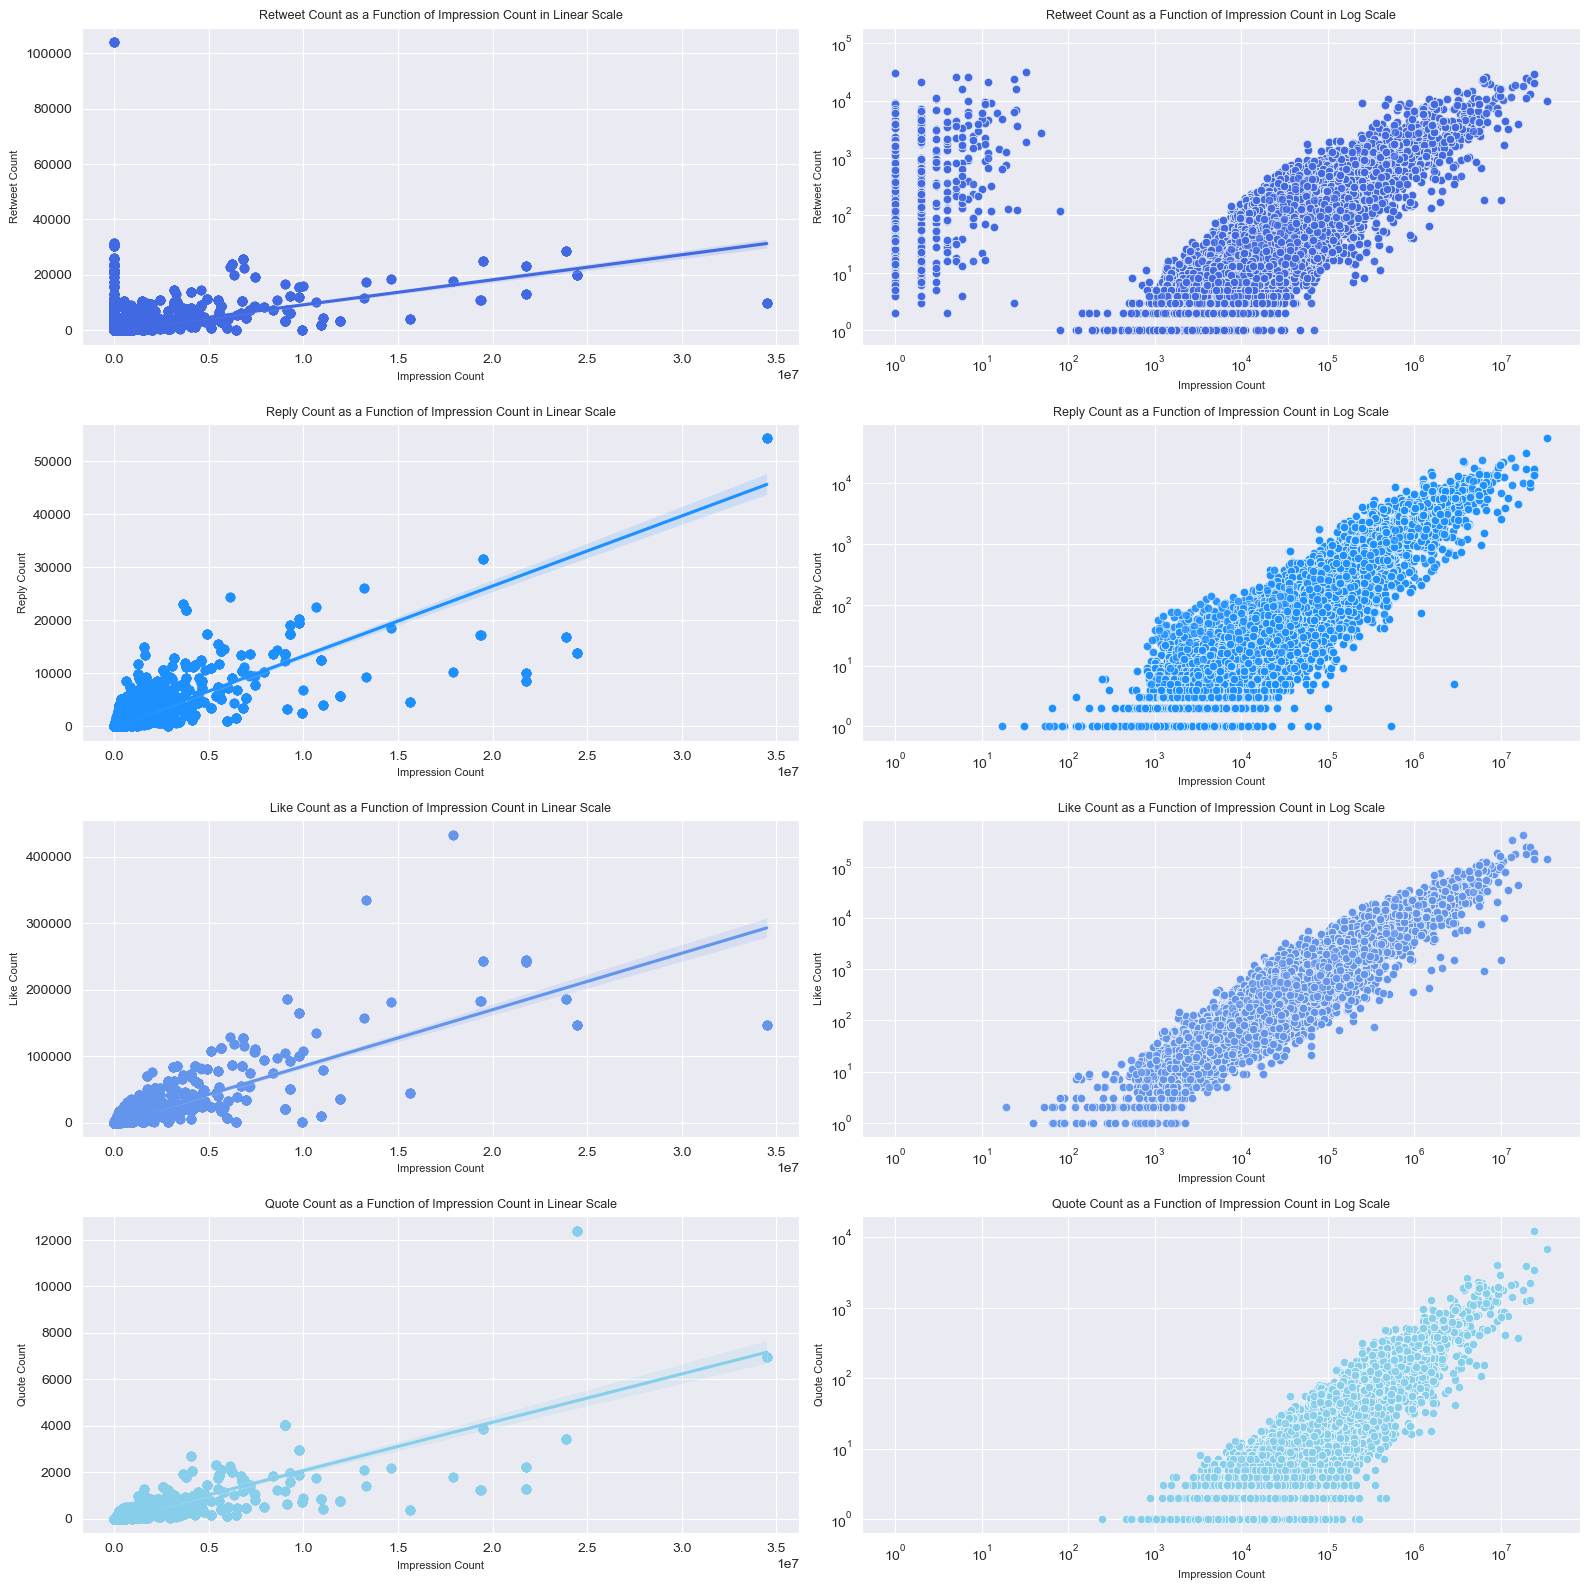

In [10]:
# Plot the scatterplots of the engagement counts against impression count
columns = ['retweet_count', 'reply_count', 'like_count', 'quote_count']
plot_scatterplots(american_politicians_df, columns, 'impression_count')

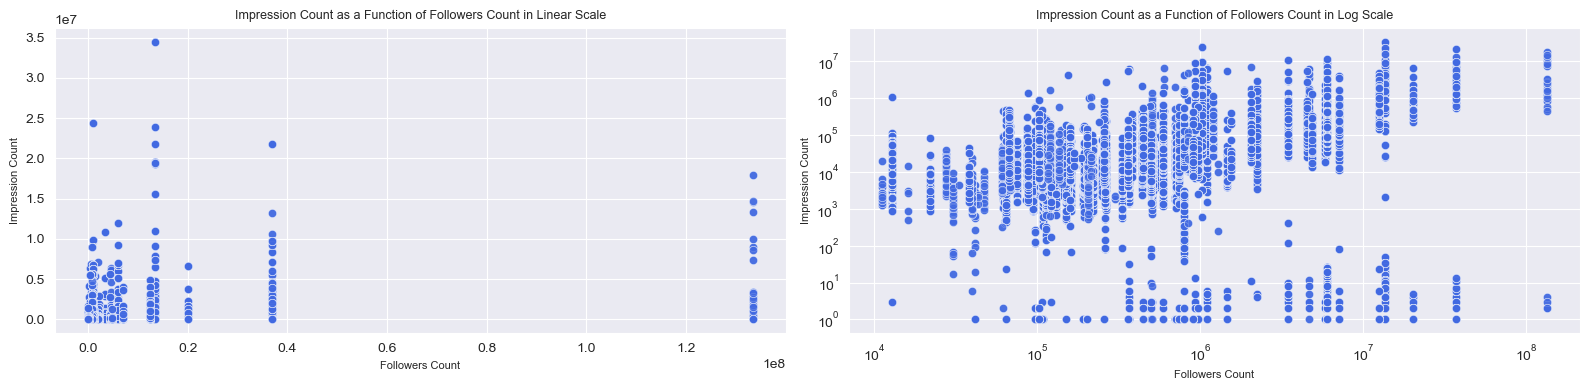

In [117]:
# Plot the scatterplots of the impression counts against follower counts
columns = ['impression_count']
plot_scatterplots(american_politicians_df, columns, 'followers_count')

### GET FEATURES FROM DATAFRAME

Tweet info:
# Tweet length  ✅
# Time of the tweet (morning, afternoon, night) ✅
# Sentiment of the tweet (score computed by model) ✅
# Number of hashtags ✅
# Number of mentions ✅
# Number of url's ✅
# Media type (video, image, text,..) => attention c un tableau
# (To clarify: location) 🚧

User info:
# Verified ✅
# Profile creation date ✅
# (To clarify: Tweet frequency) 🚧

## Extracting features from raw data

In [21]:
from pyspark.sql import SparkSession
# Import spark and open json file
spark = SparkSession.builder.getOrCreate()
df = spark.read.json('../data/american_politicians/tweets.jsonl')
json_rdd = df.rdd
df.printSchema()
spark

In [68]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime

# Function to get the sentiment of a tweet
def analyse_sentiment(x):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(x)
    return vs['compound']

# 
def add_key_value(x, key, value):
    x[key] = value
    return x


def keep_medias_only(x):
    urls = x['tweet_urls']
    if not urls:
        return []
    media_urls = [url['media_key'] for url in urls if 'media_key' in url and url['media_key']]
    return media_urls

def get_number_medias(x):
    return len(x['tweet_media_keys'])

def get_number_external_urls(x):
    return (len(x['tweet_urls']) if x['tweet_urls'] else 0) - x['tweet_medias_count']

def get_period_of_day(x):
    hour = datetime.strptime(x['tweet_date'],"%Y-%m-%dT%H:%M:%S.%fZ").hour
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'night'

In [84]:
json_rdd_data_fields =json_rdd.flatMap(lambda x: x['data']) \
.map(lambda x : {
    'tweet_text': x['text'],
    'tweet_date': x['created_at'],
    'tweet_hashtags': x['entities']['hashtags'],
    'tweet_mentions': x['entities']['mentions'],
    'tweet_urls': x['entities']['urls'], 
    'user_id': x['author_id'],
})

# adding sentiment analysis on the tweet text using vader to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'sentiment', analyse_sentiment(x['tweet_text'])))

# adding the tweet length to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_length', len(x['tweet_text'])))

# adding the number of hashtags to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'hashtags_count', len(x['tweet_hashtags'])if x['tweet_hashtags'] else 0))

# adding the number of mentions to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'mentions_count', len(x['tweet_mentions'])if x['tweet_mentions'] else 0))

# adding the media url's only to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_media_keys', keep_medias_only(x)))

# adding the number of medias to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_medias_count', get_number_medias(x)))

# adding the number of external urls to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_external_urls_count', get_number_external_urls(x)))

# adding the period of the day to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_period', get_period_of_day(x)))

json_rdd_data_fields_df = json_rdd_data_fields.toDF(['tweet_text', 'tweet_date', 'tweet_hashtags', 'tweet_mentions', 'tweet_urls', 'user_id', 'sentiment', 'tweet_length', 'hashtags_count', 'mentions_count', 'tweet_media_keys', 'tweet_medias_count', 'tweet_external_urls_count', 'tweet_period'])
json_rdd_data_fields_df.show(5)

23/04/14 17:52:36 ERROR Executor: Exception in task 0.0 in stage 90.0 (TID 276)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1469, in convert_struct
    retu

Py4JJavaError: An error occurred while calling o1773.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 90.0 failed 1 times, most recent failure: Lost task 0.0 in stage 90.0 (TID 276) (tsf-492-wpa-1-121.epfl.ch executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1469, in convert_struct
    return tuple([conv(d.get(name)) for name, conv in zip(names, converters)])
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1469, in <listcomp>
    return tuple([conv(d.get(name)) for name, conv in zip(names, converters)])
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1433, in <lambda>
    return lambda row: [conv(v) for v in row]
TypeError: 'NoneType' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1469, in convert_struct
    return tuple([conv(d.get(name)) for name, conv in zip(names, converters)])
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1469, in <listcomp>
    return tuple([conv(d.get(name)) for name, conv in zip(names, converters)])
  File "/Users/etiennebruno/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/types.py", line 1433, in <lambda>
    return lambda row: [conv(v) for v in row]
TypeError: 'NoneType' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


In [59]:
json_rdd_includes_fields =json_rdd \
.map(lambda x : {
    'user_profile_creation_date': x['includes']['users'][0]['created_at'],
    'user_verified': x['includes']['users'][0]['verified'],
    'user_creation_date': x['includes']['users'][0]['created_at'],
    'user_id': x['includes']['users'][0]['id'],
})

json_rdd_includes_fields.take(10)

[{'user_profile_creation_date': '2011-01-05T14:13:33.000Z',
  'user_verified': True,
  'user_creation_date': '2011-01-05T14:13:33.000Z',
  'user_id': '234374703'},
 {'user_profile_creation_date': '2011-01-05T14:13:33.000Z',
  'user_verified': True,
  'user_creation_date': '2011-01-05T14:13:33.000Z',
  'user_id': '234374703'},
 {'user_profile_creation_date': '2007-03-05T22:08:25.000Z',
  'user_verified': True,
  'user_creation_date': '2007-03-05T22:08:25.000Z',
  'user_id': '813286'},
 {'user_profile_creation_date': '2007-03-11T17:51:24.000Z',
  'user_verified': True,
  'user_creation_date': '2007-03-11T17:51:24.000Z',
  'user_id': '939091'},
 {'user_profile_creation_date': '2007-03-11T17:51:24.000Z',
  'user_verified': True,
  'user_creation_date': '2007-03-11T17:51:24.000Z',
  'user_id': '939091'},
 {'user_profile_creation_date': '2008-11-19T20:10:20.000Z',
  'user_verified': True,
  'user_creation_date': '2008-11-19T20:10:20.000Z',
  'user_id': '17494010'},
 {'user_profile_creation_d

In [82]:
json_rdd_media = json_rdd.flatMap(lambda x: x['includes']['media']).map(lambda x: [x["media_key"], x["type"], x["url"]] ).toDF(["media_key", "type", "url"])
json_rdd_media.show(10)

+--------------------+-----+--------------------+
|           media_key| type|                 url|
+--------------------+-----+--------------------+
|13_16292284958251...|video|                null|
|13_16291720766230...|video|                null|
|3_162886997063234...|photo|https://pbs.twimg...|
|3_162886997059040...|photo|https://pbs.twimg...|
|3_162886997060717...|photo|https://pbs.twimg...|
|3_162886997059449...|photo|https://pbs.twimg...|
|7_162882494078585...|video|                null|
|3_162882494042932...|photo|https://pbs.twimg...|
|3_162882494044196...|photo|https://pbs.twimg...|
|3_162882494059300...|photo|https://pbs.twimg...|
+--------------------+-----+--------------------+
only showing top 10 rows

